# 图像处理+180776+胡欣毅(Python版)
# 8周课后

## 1. 题目清单

1. 利用Perona-Malik算法改善图像清晰度
2. 利用Gabor算法改善图像清晰度

## Perona-Malik算法

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

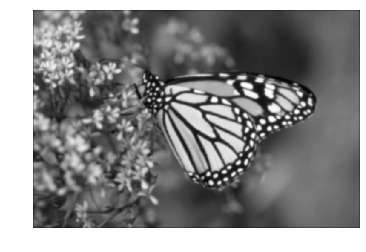

(512, 768)

In [2]:
im = cv2.imread('../hudie/3.bmp')
im = cv2.cvtColor(im , cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(im , cv2.COLOR_RGB2GRAY).astype(float)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.show()
gray.shape

In [3]:
def getImageVar(image):
    imageVar = cv2.Laplacian(image, cv2.CV_64F).var()
    return imageVar

In [4]:
def g(s,k):
    return np.exp(-(s/k)**2)

In [5]:
def get_c(grad_u,k):
    return g(abs(grad_u),k)

$$
u(x,y,\Delta t) = u(x,y, 0) + \Delta t \frac{\partial u}{\partial t}
$$

$$ \frac{\partial u}{\partial t} = \bigtriangledown (c(x,y,t) \bigtriangledown u )
= \bigtriangledown c(x,y,t) \bigtriangledown u + c(x,y,t)\Delta u  $$

$$ g(s)=exp(-(\frac{s}{k})^2) $$

$$ c(x,y,t) = g(\left | \bigtriangledown u    \right |) $$

### 方式一

In [6]:
def PM1(src ,k = 12,lambd = .01 ):
    
    Ker_x = np.array([[-1, 0, 1], 
                      [-1, 0, 1], 
                      [-1, 0, 1]])
    Ker_y = np.array([[1, 1, 1], 
                      [0, 0, 0], 
                      [-1,-1,-1]])
    # Laplace扩展算子
    laplace = np.array([[1, 1, 1],
                        [1,-8, 1],
                        [1, 1, 1]])
    # grad_u
    grad_x = cv2.filter2D(src,  -1 , Ker_x )
    grad_y = cv2.filter2D(src,  -1 , Ker_y )
    grad_u = np.abs(grad_x)  + np.abs(grad_y) 
    # c
    c = get_c(grad_u,k = k)
    # grad_c
    grad_x_c = cv2.filter2D(src,  -1 , Ker_x )
    grad_y_c = cv2.filter2D(src,  -1 , Ker_y )
    grad_c = np.abs(grad_x_c)  + np.abs(grad_y_c)  
    # Laplace_u
    Laplace_u = cv2.filter2D(src,  -1 , laplace )
    # 
    im_out = (src + lambd*(grad_c * grad_u + c* Laplace_u ) )
    return im_out

In [7]:
def PM2(src ,k = 12,lambd = .001 ):
    
    edge = - np.array([[1, 1, 1],
                       [1,-8, 1],
                       [1, 1, 1]])
    # grad_u
    grad_u = cv2.filter2D(src,  -1 , edge )
    # c
    c = get_c(grad_u,k = k)
    # grad_c
    grad_c = cv2.filter2D(src,  -1 , edge )

    # Laplace_u
    x = cv2.getGaussianKernel(3 , 1.0)#高斯滤波器
    ker = x * x.T

    Laplace_u = cv2.filter2D(src,  -1 , ker )
    # out 
    im_out = (src + lambd*(grad_c * grad_u + c* Laplace_u ) )
    return im_out

In [8]:
# 迭代次数
step_num = 1
# copy
im_out1 = gray.astype(float)
im_out2 = gray.astype(float)
for t in range(step_num):
    im_out1 = PM1( im_out1, k = 12,lambd = .002)
    im_out2 = PM2( im_out2, k = 15,lambd = .003)

In [9]:
print('原图：', getImageVar(gray),'\n','PM算法：',\
      getImageVar(im_out1),getImageVar(im_out2))

原图： 24.55965163387333 
 PM算法： 178.14737824894107 46.61359154302199


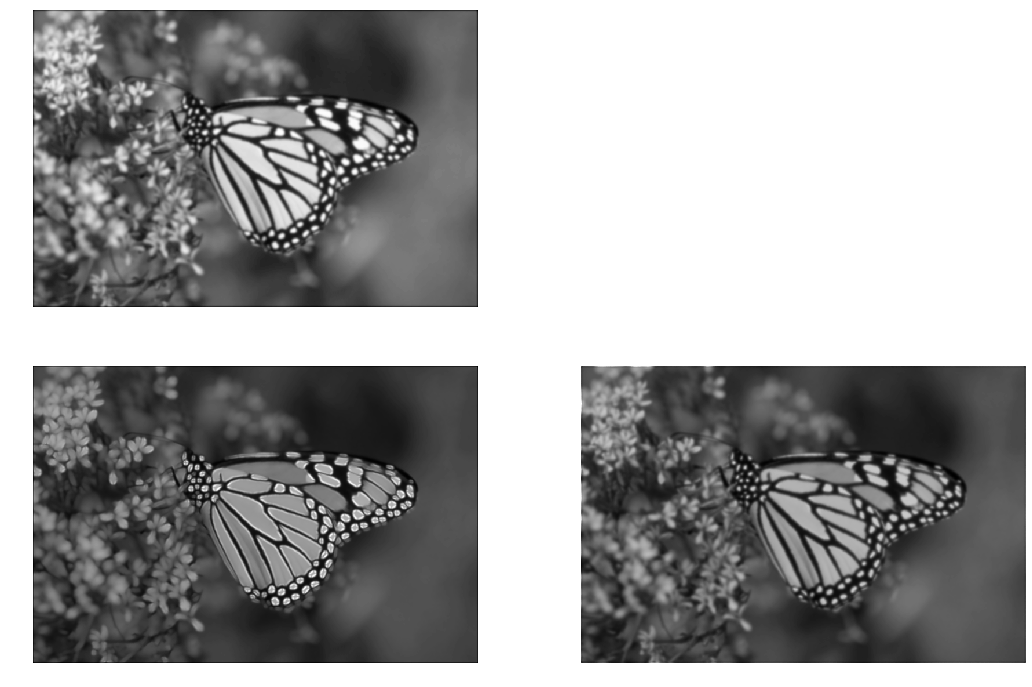

In [10]:
plt.figure(figsize=(18,12))
plt.subplot(221)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.subplot(223)
plt.imshow(im_out1,cmap='gray')
plt.axis("off")
plt.subplot(224)
plt.imshow(im_out2,cmap='gray')
plt.axis("off")
plt.show()

### 方式二

In [11]:
def f(s,k):
    return 1.0 / (1.0 + (s / k) ** 2)

In [12]:
def Perona_Malik(src , times =30,dt=.01 ,kappa =12, option = 1 ):  
    ny,nx = src.shape
    src = src.astype('float')
    # copy
    res = src
    tmp = src
    
    # 迭代次数
    for t in range(times):
        # 一次迭代
        for i in range(ny):
            for j in range(nx):
                # 位置信息 边界处理
                iUp   =  max(0,i - 1)
                iDown =  min(ny-1,i + 1)
                jLeft =  max(0,j - 1)
                jRight = min(nx-1,j + 1)
                
                # 书本page216　先计算　deta_u
                deltaN = tmp[iUp,j] - tmp[i,j]
                deltaS = tmp[iDown,j] - tmp[i,j]
                deltaE = tmp[i,jRight] - tmp[i,j]
                deltaW = tmp[i,jLeft] - tmp[i,j]
                delta_u = np.array([deltaN , deltaS , deltaE , deltaW ])
                #print(delta_u)
                
                # 计算　c
                if (option == 1):
                    c = g(np.abs(delta_u),kappa)
                elif (option == 2):
                    c = f(np.abs(delta_u),kappa)
                # 相乘相加 加权赋值
                res[i,j] += dt * (sum(c * delta_u) )
        tmp = res            
    return res

In [13]:
res = Perona_Malik(src= gray, times =40,dt=.002 ,kappa = 14, option = 1)
print('原图：', getImageVar(gray),'\n','PM算法：',getImageVar(res))

原图： 24.55965163387333 
 PM算法： 23.54068568433893


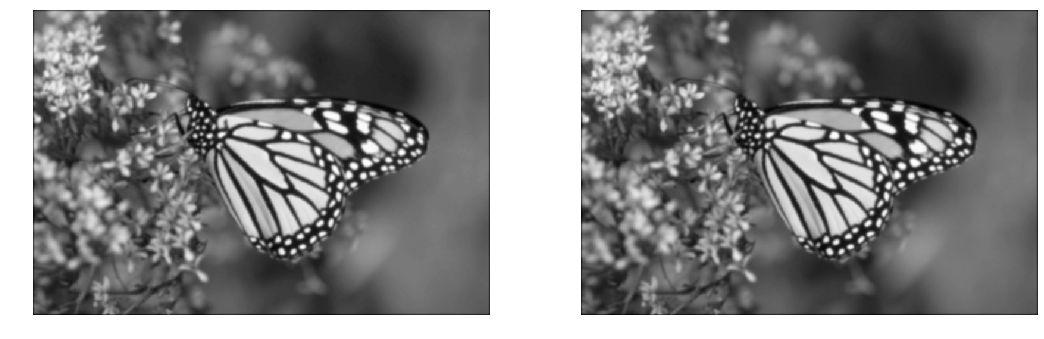

In [14]:
plt.figure(figsize=(18,15))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(res,cmap='gray')
plt.axis("off")
plt.show()

## Gabor算法

### Gabor第一算法

$$
f(x,y) = f(x,y) - t \frac{\partial^2 f }{\partial n^2}  
$$

In [15]:
def gabor1(src,t):   
    # 核 四个角度 一阶
    ker = np.zeros((3,3,4))
    ker[...,0] = np.array([[0,0,0],
                           [0,-1,1],
                           [0,0,0]])
    ker[...,1]  = np.array([[0,0,1],
                            [0,-1,0],
                            [0,0,0]])
    ker[...,2]  = np.array([[0,1,0],
                            [0,-1,0],
                            [0,0,0]])
    ker[...,3]  = np.array([[1,0,0],
                            [0,-1,0],
                            [0,0,0]])
    # 核 四个角度 二阶
    ker2 = np.zeros((3,3,4))
    ker2[...,0] = np.array([[0, 0,0],
                            [1,-2,1],
                            [0, 0,0]])
    ker2[...,1]  = np.array([[0, 0,1],
                             [0,-2,0],
                             [1, 0,0]])
    ker2[...,2]  = np.array([[0, 1,0],
                             [0,-2,0],
                             [0, 1,0]])
    ker2[...,3]  = np.array([[1, 0,0],
                             [0,-2,0],
                             [0, 0,1]])
    
    # 四个角度的差分
    d = np.zeros(src.shape +(4,))
    dd = np.zeros(src.shape +(4,))
    for i in range(4):
        d[...,i] = cv2.filter2D(src, -1 , ker[...,i])
        dd[...,i] = cv2.filter2D(src, -1 , ker2[...,i])
    
    n_f = np.ones_like(src)
    for row in range(src.shape[0]):
        for col in range(src.shape[1]):
            # 法向
            n = np.where( np.abs(d[row,col,:]) ==\
                         np.max(np.abs(d[row,col,:]) ))[0][0]

            n_f[row,col] = dd[row,col,n]
    return src - t * n_f

gabor = gabor1(gray,0.5)

In [16]:
print('原图：', getImageVar(gray),'\n','PM算法：',getImageVar(gabor))

原图： 24.55965163387333 
 PM算法： 88.80644580193461


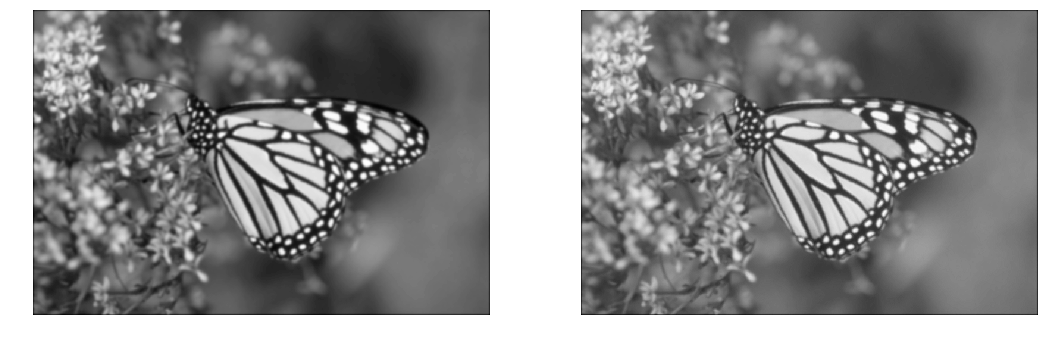

In [17]:
plt.figure(figsize=(18,15))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(gabor,cmap='gray')
plt.axis("off")
plt.show()

### Gabor第二算法

$$
f(x,y) = f(x,y) - t(\frac{\partial^2 f }{\partial n^2} - \frac{1}{3}\frac{\partial^2 f }{\partial s^2} )
$$

In [18]:
def gabor2(src,t):   
    # 核 四个角度 一阶
    ker = np.zeros((3,3,4))
    ker[...,0] = np.array([[0,0,0],
                           [0,-1,1],
                           [0,0,0]])
    ker[...,1]  = np.array([[0,0,1],
                            [0,-1,0],
                            [0,0,0]])
    ker[...,2]  = np.array([[0,1,0],
                            [0,-1,0],
                            [0,0,0]])
    ker[...,3]  = np.array([[1,0,0],
                            [0,-1,0],
                            [0,0,0]])
    # 核 四个角度 二阶
    ker2 = np.zeros((3,3,4))
    ker2[...,0] = np.array([[0, 0,0],
                            [1,-2,1],
                            [0, 0,0]])
    ker2[...,1]  = np.array([[0, 0,1],
                             [0,-2,0],
                             [1, 0,0]])
    ker2[...,2]  = np.array([[0, 1,0],
                             [0,-2,0],
                             [0, 1,0]])
    ker2[...,3]  = np.array([[1, 0,0],
                             [0,-2,0],
                             [0, 0,1]])
    
    # 四个角度的差分
    d = np.zeros(src.shape +(4,))
    dd = np.zeros(src.shape +(4,))
    for i in range(4):
        d[...,i] = cv2.filter2D(src, -1 , ker[...,i])
        dd[...,i] = cv2.filter2D(src, -1 , ker2[...,i])
    
    n_f = np.ones_like(src)
    s_f = np.ones_like(src)
    for row in range(src.shape[0]):
        for col in range(src.shape[1]):
            # 法向
            n = np.where( np.abs(d[row,col,:]) ==\
                         np.max(np.abs(d[row,col,:]) ))[0][0]
            # 切向
            s = (n+2)%4
            n_f[row,col] = dd[row,col,n]
            s_f[row,col] = dd[row,col,s]
    return src - t * (n_f - s_f /3 )

gabor = gabor2(gray,0.5)

In [19]:
print('原图：', getImageVar(gray),'\n','PM算法：',getImageVar(gabor))

原图： 24.55965163387333 
 PM算法： 77.50446275135562


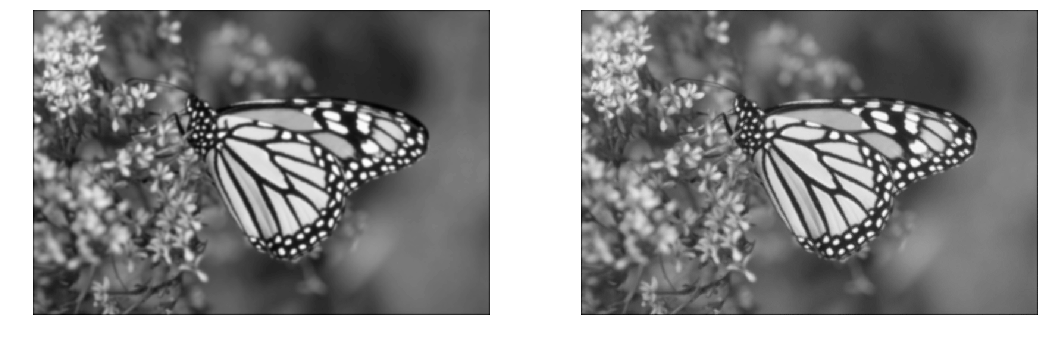

In [20]:
plt.figure(figsize=(18,15))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(gabor,cmap='gray')
plt.axis("off")
plt.show()

参考网上

In [21]:
def gabor_fn(sigma, theta, Lambda, psi, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # ------这部分内容是为了确定卷积核的大小------
    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), \
               abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), \
               abs(nstds * sigma_y * np.cos(theta)))
    
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
    # ------这部分内容是为了确定卷积核的大小------
    
    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # ------这部分正是上面的公式------
    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) \
                                        * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

In [22]:
#构建Gabor滤波器
# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype) 参数说明
def build_filter():
    ksize = (5,5)
    lamda = np.pi/2.0 # 波长
    direction = 8
    out = np.zeros(ksize)
 
    for i,theta in enumerate(np.arange(0, np.pi, np.pi / direction)):
        # gabor方向，0度，22.5度, 45度，67.5度, 90度, 
        # 112.5度，135度，157.5度 共8个
        kern = cv2.getGaborKernel(ksize,.7,theta,lamda,\
                                  gamma = 0.5, psi= 0, ktype=cv2.CV_32F)
        #np.maximum(out,kern,out)
        out += kern
    out /= out.sum()
    return out

In [23]:
res = cv2.filter2D(gray,-1,build_filter())
print('原图：', getImageVar(gray),'\n','PM算法：',getImageVar(res))

原图： 24.55965163387333 
 PM算法： 48.52537066073149


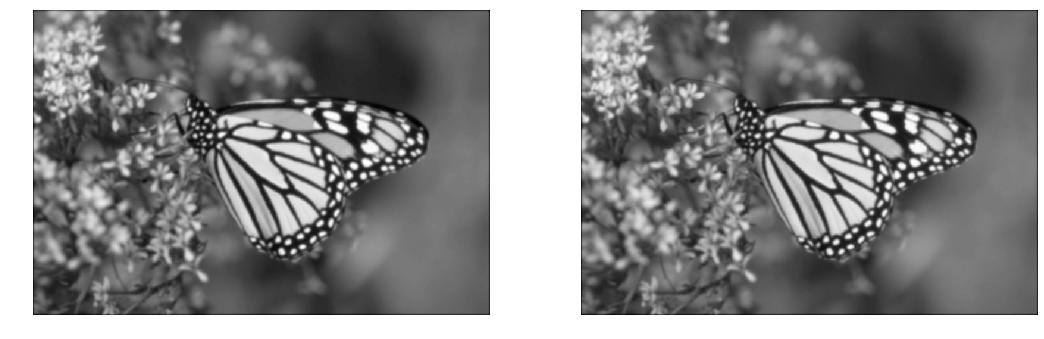

In [24]:
plt.figure(figsize=(18,15))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(res,cmap='gray')
plt.axis("off")
plt.show()

# 图像处理+180776+胡欣毅(C++版)

[c++1](c++/hxy.cpp) 、[c++2](c++/test.cpp) 